# "Predict Contribution Effort (Part 1)"

> Estimation of effort to proofread pre-translated sentences
- toc: true
- branch: master
- badges: false
- comments: true
- hide: false
- search_exclude: true
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2
- image: images/PredictContributionEffort_1.png
- categories: [Translation-Industry,  Regression,  AWS-Sagemaker,Spark,EMR,Koalas]
- show_tags: true

## 1. Purpose
Machine-translated content in longer documents can usually not be presented to users directly. There is a need for a human proofreader to verify the quality first. Many factors determine the amount of human effort needed. Because the *sentence* is a good unit of semantics it makes sense to think about effort estimation in terms of individual sentences that need to be proofread. Examples of factors that determine proofreading effort are:

* length of sentence in characters
* length of sentence in words
* source language
* target language
* role of the proofreader (e.g. first pair of human eyes, or a second proofreader)
* quality of the pre-translator (BLEU score)
* skill of the proofreader in source and target langauges

The purpose of this project is to create an effort estimation model. The client has a number of pre-translation models that vary in quality. Similarly, human proofreaders on the team has varying levels of skill. In addition, the length of documents varies. Currently, a fixed compensation is paid per document. This model will enhance fairness when the client determines the compensation for proofreaders.

## 2. Dataset and Variables
The dataset comes in the form of *contributions*, each captured as a row or data-point. Each contribution is a sentence that could be in the source language (always English) or a translation of the source sentence. There could be many variations/versions of a translated sentence, including the version provided by the translation engine initially. Human proofreaders then provide their own corrections in the form of other versions.

There are 4 kinds of contributions:

* E: English contributions
* T: Translate contributions - provided by the translation engine
* C: Create contributions - corrections provided by human proofreaders
* V: Vote contributions - whenever a human proofreader indicates agreement with a contribution provided by the translation engine, it is recorded in the form of a vote contribution

The features of the dataset are:

* m_descriptor: Unique identifier of a document
* t_lan: Language of the translation (English is also considered a translation)
* t_senc: Number of sentences in a document
* t_version: Version of a translation
* s_typ: Type of the sentence
* s_rsen: Number of a sentence within a document
* e_id: Database primary key of a contribution's content
* e_top: Content of the contribution that got the most votes
* be_id: N/A
* be_top: N/A
* c_id: Database primary key of a contribution
* c_created_at: Creation time of a contribution
* c_kind: Kind of a contribution
* c_eis: N/A
* c_base: N/A
* a_role: N/A
* u_name: N/A
* e_content: Text content of a contribution
* chars: Number of characters in a contribution
* words: Number of words in a contribution

In this notebook we will only prepare the dataset. Modeling will occur in followup notebooks.

## 3. Requirements

* Input variables:
    * document id
    * target language (source language will always be English)
    * quality of pre-translation model (with associated BLEU score)
    * role of the proofreader
    * proofreader code
* Output: The model should estimate the effort for each source (English) sentence in the document and eventually sum the estimated effort for all sentences.
* Model updates: The model should be updated periodically as new training data becomes available.
* Platform:
    * The model should be deployed on Amazon Web Services (AWS)
    * The model code should allow for a substantial growth in available data into the future 

## 4. Design
The development will be undertaken on the AWS platform, making use of Sagemaker Notebook instances. In addition, to make provision for eventual big-data needs, Apache Spark technology will be used.

Initially, because the current dataset is still relatively small, development and training will be done locally. Eventually, however, the code will be linked to an AWS Elastic Map Reduce (EMR) cluster to allow for a big-data training platform.

At a lower level, development will occur in Jupyter notebooks. Dataframes will not be used in the native Spark format, but rather making use of the relatively new Databricks *Koalas* library. The advantage of this approach is that *Koalas* allow for Spark functionality packaged as familiar pandas function calls.

Note that this notebook runs on a Sagemaker Notebook instance (VM). It is not accessed via Sagemaker Studio.

## 5. Setup

First, we import the necessary modules and create a `SparkSession` with the SageMaker-Spark dependencies attached. 

In [1]:
!python --version

Python 3.6.13


Databricks *Koalas* is central to our activities:

In [2]:
!pip install koalas
# !conda install koalas -c conda-forge #takes long!

     |████████████████████████████████| 720 kB 10.0 MB/s eta 0:00:01     |███████████▉                    | 266 kB 10.0 MB/s eta 0:00:01


In [3]:
# hide
# Lastly, if your PyArrow version is 0.15+ and your PySpark version is 
# lower than 3.0, it is best for you to set ARROW_PRE_0_15_IPC_FORMAT 
# environment variable to 1 manually. Koalas will try its best to 
# set it for you but it is impossible to set it if there is a 
# Spark context already launched.
# !ARROW_PRE_0_15_IPC_FORMAT=1

In [4]:
# 
# https://www.kaggle.com/general/185679
!pip install -U seaborn
import seaborn as sns
sns.__version__ #should be 0.11.1

'0.11.1'

In [5]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark

import numpy as np
import re
import databricks.koalas as ks
ks.__version__

'1.8.0'

In [6]:
import io
import matplotlib.pyplot as plt
import pandas as pd
pd.__version__

'1.1.5'

In [7]:
!pip list | grep pyspark

pyspark                            2.4.0
sagemaker-pyspark                  1.4.2


In [8]:
sagemaker.__version__

'2.40.0'

In [9]:
role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github to learn how to connect to EMR from a notebook instance
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()
    
spark

In [10]:
# hide
region = boto3.Session().region_name; print('region:', region)
bucket_str = "todproof-contributions-archive"
s3 = boto3.resource('s3')
bucket = s3.Bucket(bucket_str)

region: us-west-2


In [11]:
# hide
# inspect files
bucket_str = 'todproof-contributions-archive'
subfolder = 'ENG'
conn = boto3.client('s3')
contents = conn.list_objects(Bucket=bucket_str, Prefix=subfolder)['Contents']
for f in contents:
    print(f['Key'])

ENG/1948-0304_TheAngelOfGod_ENG_15-0902-b_E-contributions.csv
ENG/1949-0718_IWasNotDisobedientToTheHeavenlyVision_ENG_15-0901-b_E-contributions.csv
ENG/1950-0110_Moses_ENG_15-0901-t_E-contributions.csv
ENG/1950-0115_BelievestThouThis_ENG_15-0901-b_E-contributions.csv
ENG/1950-0200_HereWeHaveNoContinuingCity_ENG_15-0901-b_E-contributions.csv
ENG/1950-0227_GodInHisPeople_ENG_14-0901-E1R_E-contributions.csv
ENG/1950-0300_GiftsAndCallingsAreWithoutRepentance_ENG_14-0901-E1R_E-contributions.csv
ENG/1951-0508_FaithIsTheSubstance_ENG_19-0201-b_E-contributions.csv
ENG/1951-0717_TheManifestationOfTheSpirit_ENG_15-0101-b_E-contributions.csv
ENG/1951-0727_TheChurchOfTheLivingGod_ENG_15-0101-b_E-contributions.csv
ENG/1951-0729y_TheResurrectionOfLazarus_ENG_15-0101-b_E-contributions.csv
ENG/1953-0405s_GoTellMyDisciples_ENG_19-0201-b_E-contributions.csv
ENG/1953-1018_Elijah_ENG_15-0401-b_E-contributions.csv
ENG/1955-0121_TheWaterOfSeparation_ENG_15-0401-b_E-contributions.csv
ENG/1955-0123y_TheApproa

In [13]:
# 
# Koalas default index
# ks.set_option('compute.default_index_type', 'sequence')
ks.get_option('compute.default_index_type')

'sequence'

In [14]:
# hide
# # all_files = glob.glob(f"{PATH}/contributions/*E-contributions.csv") #glob does not work on S3
# # https://stackoverflow.com/questions/52855221/reading-multiple-csv-files-from-s3-bucket-with-boto3
# def read_prefix_to_df(prefix_str): #read_folder_to_df
#     prefix_objs = bucket.objects.filter(Prefix=prefix_str)
#     prefix_dfs = []
#     for obj in prefix_objs:
#         key = obj.key
#         body = obj.get()['Body'].read()
#         df_tmp = ks.read_csv(io.BytesIO(body), index_col=None, header=0, sep='~', encoding='utf8')
#         prefix_dfs.append(df_tmp)
#     return ks.concat(prefix_dfs, axis=0, ignore_index=True)

# # read_object_to_df('AFR/1958-0928z_TheSerpentsSeed_AFR_14-0101-B123_V-contributions.csv')
# def read_object_to_df(object_str): #read_file_to_df
#     obj = s3.Object(bucket_str, object_str)
#     key = obj.key
#     body = obj.get()['Body'].read()
#     return ks.read_csv(io.BytesIO(body), index_col=None, header=0, sep='~', encoding='utf8')

# # read_object_list_to_df(['AFR/1958-0928z_TheSerpentsSeed_AFR_14-0101-B123_V-contributions.csv',
# #  'AFR/1960-0607_HearingReceivingAndActing_AFR_19-0401-B123_V-contributions.csv']
# def read_object_list_to_df(object_list): #list of filenames, regardless of folder
#     obj_dfs = []
#     rows = 0
#     print('read_object_list_to_df(): length of object_list:', len(object_list))
#     print('reading files ...')
#     for i,obj_str in enumerate(object_list):
#         #print(i,obj_str)
#         print(i, end=" ")
#         df_tmp = read_object_to_df(obj_str)
#         obj_dfs.append(df_tmp)
#         rows += len(df_tmp)
#     print('\ntotal rows:', rows)
#     return ks.concat(obj_dfs, axis=0, ignore_index=True)

# # df_V = read_all_contributions('V')
# def read_all_contributions(c_kind): #c_kind: contribution kind, E, C, T, V
#     target_files = []
#     for obj in bucket.objects.filter():
#         #print(type(obj.key))
#         #print(obj.key)
#         if re.search(f'{c_kind}-contributions', obj.key):
#             target_files.append(obj.key)
#     #print(target_files)
#     return read_object_list_to_df(target_files)

## 6. Get train/valid data

In [15]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

### 6.1 Ingest all E-contributions

In [16]:
# hide
data_key = "*/*E-contributions.csv"
data_location = f"s3a://{bucket_str}/{data_key}"; print('data_location:', data_location)

data_location: s3a://todproof-contributions-archive/*/*E-contributions.csv


In [17]:
# hide
# #- df = spark.read.csv(data_location, sep='~', header=True, inferSchema=True, nullValue="", nanValue="")
# # df = spark.read.csv(data_location, sep='~', header=True, inferSchema=True, nanValue="null")
# # df = spark.read.csv(data_location, sep='~', header=True, inferSchema=True, nullValue="null")
# sdf = spark.read.csv(data_location, sep='~', header=True, inferSchema=True, nanValue=np.nan, nullValue=np.nan)
# # sdf.show()

# # df_E = sdf.toPandas()
# df_E = sdf.to_koalas(); df_E.shape

In [18]:
df_E = ks.read_csv(data_location, sep='~'); df_E.shape
#- df_E = ks.read_csv(data_location, index_col=None, header=None, sep='~', encoding='utf-8'); df_E.shape

(167289, 18)

In [23]:
df_E.iloc[:5,:-2]

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,e_id,e_top,be_id,be_top,c_id,c_created_at,c_kind,c_eis,c_base,a_role
0,1963-0728,ENG,3706,15-0402-b,h,1,733089,Z,None,None,1099529,2020-06-09 21:05:24.117,E,0,None,EP
1,1963-0728,ENG,3706,15-0402-b,n,2,733090,Z,None,None,1099530,2020-06-09 21:05:24.142,E,0,None,EP
2,1963-0728,ENG,3706,15-0402-b,n,3,733091,Z,None,None,1099531,2020-06-09 21:05:24.166,E,0,None,EP
3,1963-0728,ENG,3706,15-0402-b,n,4,733092,Z,None,None,1099532,2020-06-09 21:05:24.191,E,0,None,EP
4,1963-0728,ENG,3706,15-0402-b,n,5,733093,Z,None,None,1099533,2020-06-09 21:05:24.219,E,0,None,EP


In [19]:
# hide
#- df_E = read_all_contributions('E')
# df_E.iloc[:5,:-2]

In [20]:
df_E.info()

databricks.koalas.frame.DataFrame
Int64Index: 167289 entries, 0 to 167288
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   m_descriptor  167289 non-null  object        
 1   t_lan         167289 non-null  object        
 2   t_senc        167289 non-null  int32         
 3   t_version     167289 non-null  object        
 4   s_typ         167289 non-null  object        
 5   s_rsen        167289 non-null  int32         
 6   e_id          167289 non-null  int32         
 7   e_top         167289 non-null  object        
 8   be_id         0 non-null       object        
 9   be_top        0 non-null       object        
 10  c_id          167289 non-null  int32         
 11  c_created_at  167289 non-null  datetime64[ns]
 12  c_kind        167289 non-null  object        
 13  c_eis         167289 non-null  int32         
 14  c_base        0 non-null       object        
 15  a_role        167289 

In [21]:
# hide
# maybe i can keep the Nones?
# import numpy as np
# mymap = {'None': np.nan}
# df_E['be_id'] = df_E['be_id'].map(mymap)
# df_E['be_top'] = df_E['be_top'].map(mymap)
# df_E['c_base'] = df_E['c_base'].map(mymap)
# # df_E['e_content'] = df_E['e_content'].map(mymap)

In [22]:
# hide
df_E.head()

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,e_id,e_top,be_id,be_top,c_id,c_created_at,c_kind,c_eis,c_base,a_role,u_name,e_content
0,1963-0728,ENG,3706,15-0402-b,h,1,733089,Z,None,None,1099529,2020-06-09 21:05:24.117,E,0,None,EP,kobest,Christ Is The Mystery Of God Revealed
1,1963-0728,ENG,3706,15-0402-b,n,2,733090,Z,None,None,1099530,2020-06-09 21:05:24.142,E,0,None,EP,kobest,"Thank you, Brother Neville."
2,1963-0728,ENG,3706,15-0402-b,n,3,733091,Z,None,None,1099531,2020-06-09 21:05:24.166,E,0,None,EP,kobest,The Lord bless you.
3,1963-0728,ENG,3706,15-0402-b,n,4,733092,Z,None,None,1099532,2020-06-09 21:05:24.191,E,0,None,EP,kobest,Just remain standing a moment while we bow our...
4,1963-0728,ENG,3706,15-0402-b,n,5,733093,Z,None,None,1099533,2020-06-09 21:05:24.219,E,0,None,EP,kobest,"Gracious Heavenly Father, we’re approaching Th..."


In [24]:
# 
# drop features that won't be used
df_E = df_E.drop(['e_id','e_top','be_id','be_top','c_id','c_created_at','c_kind','c_eis','c_base','a_role','u_name'], axis=1)
df_E.iloc[:5,:-1]

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen
0,1963-0728,ENG,3706,15-0402-b,h,1
1,1963-0728,ENG,3706,15-0402-b,n,2
2,1963-0728,ENG,3706,15-0402-b,n,3
3,1963-0728,ENG,3706,15-0402-b,n,4
4,1963-0728,ENG,3706,15-0402-b,n,5


In [25]:
#hide
df_E.head()

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,e_content
0,1963-0728,ENG,3706,15-0402-b,h,1,Christ Is The Mystery Of God Revealed
1,1963-0728,ENG,3706,15-0402-b,n,2,"Thank you, Brother Neville."
2,1963-0728,ENG,3706,15-0402-b,n,3,The Lord bless you.
3,1963-0728,ENG,3706,15-0402-b,n,4,Just remain standing a moment while we bow our...
4,1963-0728,ENG,3706,15-0402-b,n,5,"Gracious Heavenly Father, we’re approaching Th..."


In [26]:
# 
# handle NaNs in e_content
e_content_nans = df_E['e_content'].isna()
df_E[e_content_nans]

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,e_content
99927,1956-0805,ENG,1430,15-0402-b,n,1176,None
162847,1957-0419,ENG,645,15-0401-b,n,505,None


In [27]:
# 
#replace e_content NaNs with empty strings
df_E.loc[e_content_nans, 'e_content'] = ''
# df_E.loc[e_content_nans, ['e_content']]
# OR
df_E[df_E['e_content']=='']

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,e_content
99927,1956-0805,ENG,1430,15-0402-b,n,1176,
162847,1957-0419,ENG,645,15-0401-b,n,505,


In [28]:
# 
# add chars column
#- df_E['chars'] = [len(e) for e in df_E['e_content']] #does not work with Koalas
df_E['chars'] = df_E['e_content'].apply(len)
df_E.loc[:5,['m_descriptor','t_lan','t_version','s_rsen','chars']]

,m_descriptor,t_lan,t_version,s_rsen,chars
0,1963-0728,ENG,15-0402-b,1,37
1,1963-0728,ENG,15-0402-b,2,27
2,1963-0728,ENG,15-0402-b,3,19
3,1963-0728,ENG,15-0402-b,4,64
4,1963-0728,ENG,15-0402-b,5,312
5,1963-0728,ENG,15-0402-b,6,360


In [29]:
# hide
df_E.head()

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,e_content,chars
0,1963-0728,ENG,3706,15-0402-b,h,1,Christ Is The Mystery Of God Revealed,37
1,1963-0728,ENG,3706,15-0402-b,n,2,"Thank you, Brother Neville.",27
2,1963-0728,ENG,3706,15-0402-b,n,3,The Lord bless you.,19
3,1963-0728,ENG,3706,15-0402-b,n,4,Just remain standing a moment while we bow our...,64
4,1963-0728,ENG,3706,15-0402-b,n,5,"Gracious Heavenly Father, we’re approaching Th...",312


In [30]:
# 
# df_E.loc[e_content_nans, ['e_content','chars']]
# OR
df_E[df_E['chars']==0]

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,e_content,chars
99927,1956-0805,ENG,1430,15-0402-b,n,1176,,0
162847,1957-0419,ENG,645,15-0401-b,n,505,,0


In [31]:
# 
# add words column
# https://www.geeksforgeeks.org/python-program-to-count-words-in-a-sentence/
#- df_E['words'] = [len(re.findall(r'\w+', e)) for e in df_E['e_content']] #does not work in Koalas
df_E['words'] = df_E['e_content'].apply(lambda e: len(re.findall(r'\w+', e)))
df_E.loc[:5,['m_descriptor','t_lan','t_senc','t_version','s_typ','s_rsen','chars','words']]

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,chars,words
0,1963-0728,ENG,3706,15-0402-b,h,1,37,7
1,1963-0728,ENG,3706,15-0402-b,n,2,27,4
2,1963-0728,ENG,3706,15-0402-b,n,3,19,4
3,1963-0728,ENG,3706,15-0402-b,n,4,64,12
4,1963-0728,ENG,3706,15-0402-b,n,5,312,61
5,1963-0728,ENG,3706,15-0402-b,n,6,360,70


In [32]:
# hide
df_E.head()

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,e_content,chars,words
0,1963-0728,ENG,3706,15-0402-b,h,1,Christ Is The Mystery Of God Revealed,37,7
1,1963-0728,ENG,3706,15-0402-b,n,2,"Thank you, Brother Neville.",27,4
2,1963-0728,ENG,3706,15-0402-b,n,3,The Lord bless you.,19,4
3,1963-0728,ENG,3706,15-0402-b,n,4,Just remain standing a moment while we bow our...,64,12
4,1963-0728,ENG,3706,15-0402-b,n,5,"Gracious Heavenly Father, we’re approaching Th...",312,61


In [33]:
# 
#remove BER part of version from t_version so that we can use this 
# column to join the English contributions with their matching 
# translated contributions
#- df_E['t_version'] = ['-'.join(e.split('-')[:2]) for e in df_E['t_version']] #does not work in Koalas
df_E['t_version'] = df_E['t_version'].apply(lambda e: '-'.join(e.split('-')[:2]))
df_E.loc[:5,['m_descriptor','t_lan','t_senc','t_version','s_typ','s_rsen','chars','words']]

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,chars,words
0,1963-0728,ENG,3706,15-0402,h,1,37,7
1,1963-0728,ENG,3706,15-0402,n,2,27,4
2,1963-0728,ENG,3706,15-0402,n,3,19,4
3,1963-0728,ENG,3706,15-0402,n,4,64,12
4,1963-0728,ENG,3706,15-0402,n,5,312,61
5,1963-0728,ENG,3706,15-0402,n,6,360,70


In [34]:
# hide
df_E.head()

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,e_content,chars,words
0,1963-0728,ENG,3706,15-0402,h,1,Christ Is The Mystery Of God Revealed,37,7
1,1963-0728,ENG,3706,15-0402,n,2,"Thank you, Brother Neville.",27,4
2,1963-0728,ENG,3706,15-0402,n,3,The Lord bless you.,19,4
3,1963-0728,ENG,3706,15-0402,n,4,Just remain standing a moment while we bow our...,64,12
4,1963-0728,ENG,3706,15-0402,n,5,"Gracious Heavenly Father, we’re approaching Th...",312,61


### 6.2 Ingest all C-contributions and V-contributions

In [35]:
# hide
data_key = "*/*C-contributions.csv"
data_location = f"s3a://{bucket_str}/{data_key}"; print('data_location:', data_location)

data_location: s3a://todproof-contributions-archive/*/*C-contributions.csv


In [36]:
# hide
# sdf = spark.read.csv(data_location, sep='~', header=True, inferSchema=True)
# df_V = sdf.to_koalas(); df_V.shape

In [37]:
#- df_C = ks.read_csv(data_location, index_col=None, header=None, sep='~', encoding='utf-8'); df_C.shape
df_C = ks.read_csv(data_location, sep='~'); df_C.shape

(177283, 18)

In [38]:
df_C.iloc[:5,:-2]

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,e_id,e_top,be_id,be_top,c_id,c_created_at,c_kind,c_eis,c_base,a_role
0,1963-0728,FIJ,3714,15-0401-B123,n,2,51283,M,NaN,None,60569,2017-07-03 00:58:53.572,C,22,None,TE
1,1963-0728,FIJ,3714,15-0401-B123,n,3,51284,M,NaN,None,60570,2017-07-03 01:01:31.919,C,144,None,TE
2,1963-0728,FIJ,3714,15-0401-B123,n,4,51285,M,NaN,None,60572,2017-07-03 01:16:49.033,C,901,None,TE
3,1963-0728,FIJ,3714,15-0401-B123,n,5,51286,M,NaN,None,60574,2017-07-03 02:19:45.848,C,740,None,TE
4,1963-0728,FIJ,3714,15-0401-B123,n,6,51287,M,NaN,None,60576,2017-07-03 02:35:33.669,C,875,None,TE


In [39]:
# hide
data_key = "*/*V-contributions.csv"
data_location = f"s3a://{bucket_str}/{data_key}"; print('data_location:', data_location)

data_location: s3a://todproof-contributions-archive/*/*V-contributions.csv


In [40]:
df_V = ks.read_csv(data_location, sep='~'); df_V.shape

(382895, 18)

In [41]:
df_CV = ks.concat([df_C, df_V], axis=0); df_CV.shape

(560178, 18)

In [42]:
# hide
# df_CV = df_CV.drop(['t_senc','s_typ','be_id','c_eis'], axis=1)
# df_CV

In [43]:
tmp = df_CV.sort_values(by=['m_descriptor', 't_lan','t_version','s_rsen','a_role','u_name','c_created_at'])

In [44]:
# hide
tmp[2050:2060]

,m_descriptor,t_lan,t_senc,t_version,s_typ,s_rsen,e_id,e_top,be_id,be_top,c_id,c_created_at,c_kind,c_eis,c_base,a_role,u_name,e_content
370220,1948-0304,GER,1165,15-0902-B123,c,1134,464607,M,NaN,None,671918,2019-08-07 16:50:25.200,V,0,c,TE,hugmes,"Er sagte: „Bruder Branham.“ sagte: „Doktor, da..."
163725,1948-0304,GER,1165,15-0902-B123,c,1134,464607,M,NaN,None,671919,2019-08-07 16:52:07.115,C,101,k,TE,hugmes,"Er sagte: „Bruder Branham.“ sagte: „Doktor, da..."
163726,1948-0304,GER,1165,15-0902-B123,n,1135,464608,M,457273.0,N,671920,2019-08-07 16:53:30.220,C,49,k,TE,hugmes,"Da waren sie; Sagen Sie genau das, was der Arz..."
370221,1948-0304,GER,1165,15-0902-B123,n,1135,464608,M,457273.0,N,671921,2019-08-07 16:53:30.332,V,0,c,TE,hugmes,"Da waren sie; Sagen Sie genau das, was der Arz..."
163727,1948-0304,GER,1165,15-0902-B123,n,1136,464609,M,457274.0,N,671922,2019-08-07 16:54:00.088,C,22,m,TE,hugmes,"Sagte: „Nun, meine Frau."""""
370222,1948-0304,GER,1165,15-0902-B123,n,1136,464609,M,457274.0,N,671923,2019-08-07 16:54:00.209,V,0,c,TE,hugmes,"Sagte: „Nun, meine Frau."""""
370223,1948-0304,GER,1165,15-0902-B123,n,1137,457275,M,457275.0,M,671924,2019-08-07 16:54:22.149,V,6,a,TE,hugmes,Sie kommen vorbei.
163728,1948-0304,GER,1165,15-0902-B123,c,1138,464610,M,457276.0,N,671925,2019-08-07 16:55:05.159,C,41,m,TE,hugmes,Ich sagte: „Das Baby das Nierenleiden von der ...
370224,1948-0304,GER,1165,15-0902-B123,c,1138,464610,M,457276.0,N,671926,2019-08-07 16:55:05.270,V,0,c,TE,hugmes,Ich sagte: „Das Baby das Nierenleiden von der ...
370225,1948-0304,GER,1165,15-0902-B123,n,1139,464612,M,NaN,None,671928,2019-08-07 16:57:15.390,V,0,c,TE,hugmes,"Und eine andere Sache, du hast die ganze Zeit ..."


In [54]:
# tmp = df_CV.sort_values(by=['m_descriptor', 't_lan','t_version','s_rsen','a_role','u_name','c_created_at'])
df_aggd_CV = df_CV.groupby(['m_descriptor', 't_lan','t_version','s_rsen','a_role','u_name']).agg({'c_eis':['sum','count'], 'e_content':'last'})
df_aggd_CV.shape

(382157, 3)

In [55]:
# hide
# df_aggd_CV[2000:2050]

In [56]:
df_aggd_CV = df_aggd_CV.reset_index(); df_aggd_CV.shape

(382157, 9)

In [57]:
# hide
df_aggd_CV.head()
# df_aggd_CV.iloc[:5,:-1]
#- df_aggd_CV.loc[:5,['m_descriptor','t_lan','t_version','s_rsen','a_role',['c_eis']['sum'],'c_eis_count']]

m_descriptor t_lan     t_version s_rsen a_role  u_name c_eis                                                                                        e_content
                                                           sum count                                                                                       last
0    1948-0304   POR  15-0902-B123     50     QE  kobes2     5     1                    Eu vou fazer tudo o que posso por vocês para tentar provar que vos amo.
1    1948-0304   POR  15-0902-B123     87     TE  olisil    22     2  [Espaço em branco na fita - Ed.] sentir a vibração, porque a artrite é causada por ácido.
2    1948-0304   POR  15-0902-B123    189     TE  olisil    52     2                                       A coisa que procura já está no cofre do céu para si.
3    1948-0304   POR  15-0902-B123    259     QE  kobes2     4     1                                                                              Vou ouvi-los.
4    1948-0304   POR  15-0902-B123    262     CE  pausil     6     1                                                                                        Vê?

In [58]:
df_aggd_CV.columns

MultiIndex([('m_descriptor',      ''),
            (       't_lan',      ''),
            (   't_version',      ''),
            (      's_rsen',      ''),
            (      'a_role',      ''),
            (      'u_name',      ''),
            (       'c_eis',   'sum'),
            (       'c_eis', 'count'),
            (   'e_content',  'last')],
           )

In [59]:
df_aggd_CV.columns = ['m_descriptor','t_lan','t_version','s_rsen','a_role','u_name','c_eis_sum','c_eis_count','e_content']
df_aggd_CV.loc[:5,['m_descriptor','t_lan','t_version','s_rsen','a_role','c_eis_sum','c_eis_count']]

,m_descriptor,t_lan,t_version,s_rsen,a_role,c_eis_sum,c_eis_count
0,1963-0728,FIJ,15-0401-B123,7,TE,196,2
1,1963-0728,FIJ,15-0401-B123,45,TE,66,3
2,1963-0728,FIJ,15-0401-B123,200,TE,739,3
3,1963-0728,FIJ,15-0401-B123,224,TE,909,2
4,1963-0728,FIJ,15-0401-B123,255,TE,899,2
5,1963-0728,FIJ,15-0401-B123,266,QE,11,2


In [60]:
# hide
# handle NaNs in e_content
e_content_nans = df_aggd_CV['e_content'].isna()
df_aggd_CV[e_content_nans]

,m_descriptor,t_lan,t_version,s_rsen,a_role,u_name,c_eis_sum,c_eis_count,e_content
11689,1953-0405s,CHN,19-0201-h,1153,TE,dawnxu,17,1,None
13847,1960-0607,CHN,19-0401-h,899,TE,dawnxu,3,1,None
19565,1960-0607,CHN,19-0401-h,904,TE,dawnxu,6,1,None
48182,1960-0607,CHN,19-0401-h,1153,TE,dawnxu,7,1,None
57777,1960-0607,CHN,19-0401-h,898,TE,dawnxu,9,1,None
80691,1957-0419,BEM,15-0401-B123,505,TE,davmwa,4,1,None
101991,1960-0607,CHN,19-0401-h,902,TE,dawnxu,9,1,None
109519,1955-1118,CHN,15-0401-h,18,TE,estzhe,13,1,None
154032,1960-0607,CHN,19-0401-h,908,TE,dawnxu,2,1,None
163382,1957-0114,CHN,19-0701-h,1204,TE,dawnxu,2,1,None


In [61]:
# hide
#replace e_content NaNs with empty strings
df_aggd_CV.loc[e_content_nans, 'e_content'] = ''
# df_aggd_CV.loc[e_content_nans, ['e_content']]
# OR
df_aggd_CV[df_aggd_CV['e_content']=='']

,m_descriptor,t_lan,t_version,s_rsen,a_role,u_name,c_eis_sum,c_eis_count,e_content
11689,1953-0405s,CHN,19-0201-h,1153,TE,dawnxu,17,1,
13847,1960-0607,CHN,19-0401-h,899,TE,dawnxu,3,1,
19565,1960-0607,CHN,19-0401-h,904,TE,dawnxu,6,1,
48182,1960-0607,CHN,19-0401-h,1153,TE,dawnxu,7,1,
57777,1960-0607,CHN,19-0401-h,898,TE,dawnxu,9,1,
80691,1957-0419,BEM,15-0401-B123,505,TE,davmwa,4,1,
101991,1960-0607,CHN,19-0401-h,902,TE,dawnxu,9,1,
109519,1955-1118,CHN,15-0401-h,18,TE,estzhe,13,1,
154032,1960-0607,CHN,19-0401-h,908,TE,dawnxu,2,1,
163382,1957-0114,CHN,19-0701-h,1204,TE,dawnxu,2,1,


In [62]:
# hide
# #add chars column
# df_aggd_CV['chars'] = [len(e) for e in df_aggd_CV['e_content']] #TypeError: object of type 'float' has no len()
# df_aggd_CV

In [63]:
# hide
# # df_aggd_CV.loc[e_content_nans, ['e_content','chars']]
# # OR
# df_aggd_CV[df_aggd_CV['chars']==0]

In [64]:
# hide
# #add words column
# #https://www.geeksforgeeks.org/python-program-to-count-words-in-a-sentence/
# df_aggd_CV['words'] = [len(re.findall(r'\w+', e)) for e in df_aggd_CV['e_content']]
# df_aggd_CV

In [65]:
# hide
# df_aggd_CV[df_aggd_CV['words']==0]

In [66]:
# 
# remove BER from t_version
#- df_aggd_CV['t_version'] = ['-'.join(e.split('-')[:2]) for e in df_aggd_CV['t_version']] #does not work in Koalas
df_aggd_CV['t_version'] = df_aggd_CV['t_version'].apply(lambda e: '-'.join(e.split('-')[:2]))
df_aggd_CV.loc[:5,['m_descriptor','t_lan','t_version','s_rsen','a_role','c_eis_sum','c_eis_count']]

,m_descriptor,t_lan,t_version,s_rsen,a_role,c_eis_sum,c_eis_count
0,1963-0728,FIJ,15-0401,7,TE,196,2
1,1963-0728,FIJ,15-0401,45,TE,66,3
2,1963-0728,FIJ,15-0401,200,TE,739,3
3,1963-0728,FIJ,15-0401,224,TE,909,2
4,1963-0728,FIJ,15-0401,255,TE,899,2
5,1963-0728,FIJ,15-0401,266,QE,11,2


### 6.3 Merge E and CV dataframes

In [67]:
# hide
# # ks.merge??
# >>> merged = ks.merge(df1, df2, left_on='lkey', right_on='rkey')
# >>> merged.sort_values(by=['lkey', 'value_x', 'rkey', 'value_y']) 

In [68]:
# 
# df_aggd_joind_E_CV = ks.merge(df_E, df_aggd_CV, how='inner', on=['m_descriptor', 't_version', 's_rsen'], suffixes=('_E', '_CV'), sort=True) #sort not proper here
df_aggd_joind_E_CV = ks.merge(df_E, df_aggd_CV, how='inner', on=['m_descriptor', 't_version', 's_rsen'], suffixes=('_E', '_CV'))
df_aggd_joind_E_CV.sort_values(by=['m_descriptor', 't_version', 's_rsen'])
df_aggd_joind_E_CV.loc[20:30,['m_descriptor','t_lan_E','t_senc','t_version','s_typ','s_rsen','chars','words','t_lan_CV','a_role','c_eis_sum','c_eis_count']]

,m_descriptor,t_lan_E,t_senc,t_version,s_typ,s_rsen,chars,words,t_lan_CV,a_role,c_eis_sum,c_eis_count
20,1963-0630z,ENG,2683,15-0403,n,1272,82,12,BEM,CE,55,2
21,1963-0630z,ENG,2683,15-0403,n,2160,64,14,BEM,TE,184,2
22,1963-0630z,ENG,2683,15-0403,n,2277,128,22,BEM,TE,163,2
23,1963-0630z,ENG,2683,15-0403,c,2322,76,17,BEM,TE,82,2
24,1963-0630z,ENG,2683,15-0403,n,2360,22,4,BEM,CE,25,2
25,1963-0630z,ENG,2683,15-0403,n,2402,43,9,BEM,TE,66,2
26,1963-0728,ENG,3706,15-0402,n,775,7,2,AFR,TE,7,2
27,1963-0728,ENG,3706,15-0402,n,1073,83,17,AFR,TE,79,2
28,1963-0728,ENG,3706,15-0402,n,1465,69,13,AFR,TE,45,2
29,1963-0728,ENG,3706,15-0402,n,1530,59,14,AFR,TE,25,2


In [69]:
df_aggd_joind_E_CV.shape

(382157, 15)

In [70]:
# 
# rename
df = df_aggd_joind_E_CV.copy()

In [71]:
# 
# inspect range of ENG chars and words, and OTH c_eis_sum
#- display_all(ks.describe(include='all').T)
display_all(df.describe().T)
# conclusion: min and max are fine for both

,count,mean,std,min,25%,50%,75%,max
t_senc,382157.0,1604.499140,601.625867,233.0,1215.0,1544.0,1803.0,3714.0
s_rsen,382157.0,796.977975,576.160495,1.0,344.0,710.0,1139.0,3714.0
chars,382157.0,59.645394,48.458367,0.0,26.0,46.0,80.0,621.0
words,382157.0,11.880999,9.370457,0.0,5.0,9.0,16.0,120.0
c_eis_sum,382157.0,57.017639,1684.807546,1.0,4.0,13.0,44.0,929396.0
c_eis_count,382157.0,1.465201,0.548948,1.0,1.0,1.0,2.0,8.0


In [76]:
df.columns

Index(['m_descriptor', 't_lan_E', 't_senc', 't_version', 's_typ', 's_rsen',
       'e_content_E', 'chars', 'words', 't_lan_CV', 'a_role', 'u_name',
       'c_eis_sum', 'c_eis_count', 'e_content_CV'],
      dtype='object')

In [77]:
# hide
# confirmed the following rather unusual case!
df[df['c_eis_count']==8]

,m_descriptor,t_lan_E,t_senc,t_version,s_typ,s_rsen,e_content_E,chars,words,t_lan_CV,a_role,u_name,c_eis_sum,c_eis_count,e_content_CV
32383,1965-1128z,ENG,1426,17-0501,n,91,"And when he give them to me, he hadn’t noticed...",132,26,FIJ,TE,pitrai,819,8,"Ka ni a solia ira vei au, a sega ni raica e, i..."


In [78]:
# hide
#confirmed the following rather unusual case!
df[df['c_eis_sum']==929396]

,m_descriptor,t_lan_E,t_senc,t_version,s_typ,s_rsen,e_content_E,chars,words,t_lan_CV,a_role,u_name,c_eis_sum,c_eis_count,e_content_CV
336540,1965-1206,ENG,1711,14-0901,n,61,"The little mother setting, sad, holding that l...",69,12,FIJ,TE,vatkau,929396,6,"Na tinani gone lailai dabe toka, rarawa, taura..."


In [79]:
# hide
f"{(929396/60)/60} hours!!!"

'258.16555555555556 hours!!!'

## 7. Inspect distribution of output data-points

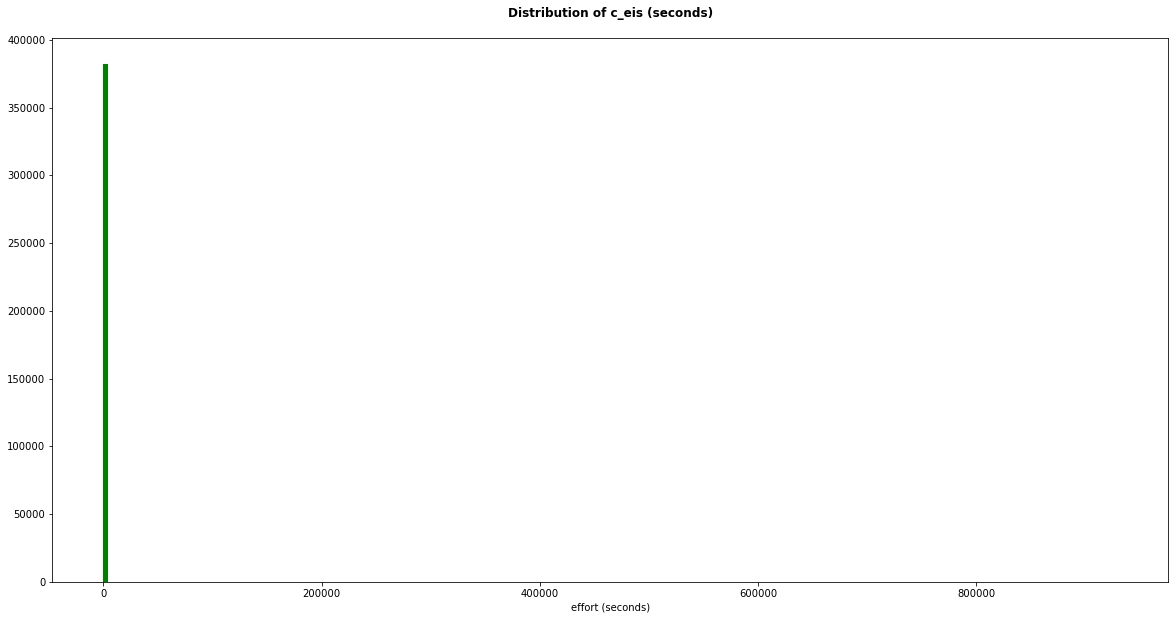

In [72]:
plt.figure(figsize=(20,10))
colors = ['green']
plt.hist(df['c_eis_sum'], bins=200, density=False, histtype='bar', color=colors, label=colors)
plt.title('Distribution of c_eis (seconds)\n', fontweight ="bold")
plt.xlabel("effort (seconds)")
plt.show()

In [73]:
# hide
# plt.figure(figsize=(20,10))
# sns.histplot(df['c_eis_sum'], bins=100); #does not seem to work with Koalas df
# sns.histplot(df.to_pandas()['c_eis_sum'], bins=100)

In [74]:
# hide
# sns.pairplot(df.to_pandas())
# EOFError

In [75]:
# 
# remove outliers
df_deoutlrd = df[df['c_eis_sum']<180] #less than 3 minutes
# df_deoutlrd = df[df['c_eis_sum']<300] #less than 5 minutes
# df_deoutlrd = df[df['c_eis_sum']<600] #less than 10 minutes
# df_deoutlrd = df[df['c_eis_sum']<1200] #less than 20 minutes

In [76]:
# hide
#- df_deoutlrd.plot.hist(bins=12, alpha=0.5)

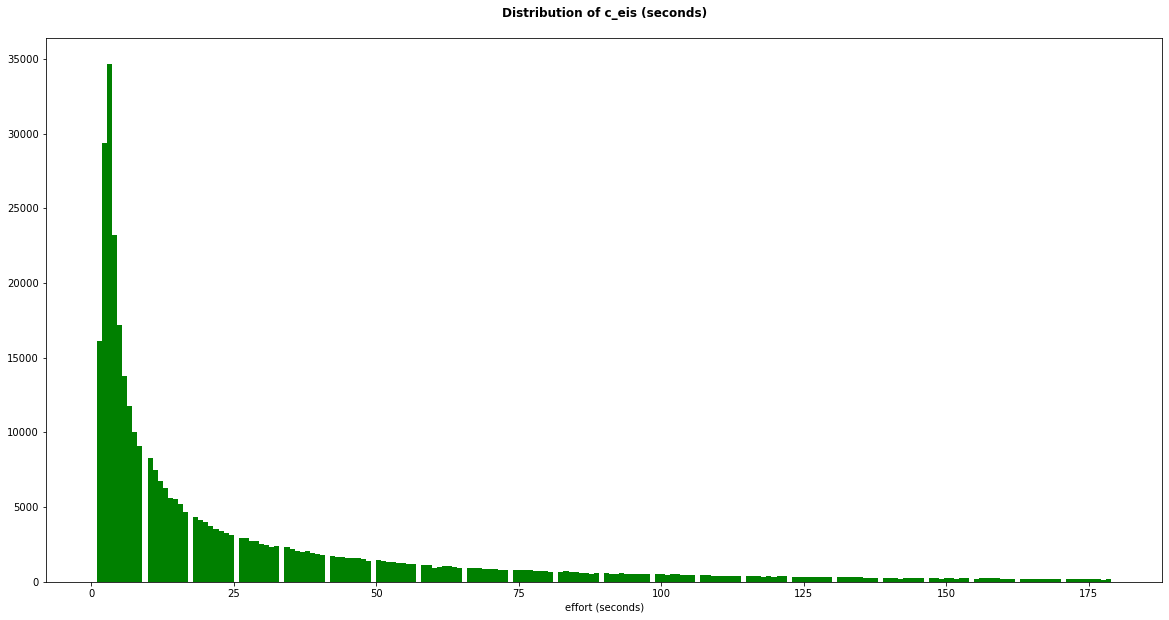

In [77]:
plt.figure(figsize=(20,10))
colors = ['green']
plt.hist(df_deoutlrd['c_eis_sum'], bins=200, density=False, histtype='bar', color=colors, label=colors)
plt.title('Distribution of c_eis (seconds)\n', fontweight ="bold")
plt.xlabel("effort (seconds)")
plt.show()

In [78]:
df_deoutlrd.columns

Index(['m_descriptor', 't_lan_E', 't_senc', 't_version', 's_typ', 's_rsen',
       'e_content_E', 'chars', 'words', 't_lan_CV', 'a_role', 'u_name',
       'c_eis_sum', 'c_eis_count', 'e_content_CV'],
      dtype='object')

In [79]:
# hide
# does not show
# %matplotlib inline  
# df_deoutlrd.plot.scatter(x='chars', y='c_eis_sum')
# fig = df_deoutlrd.plot.scatter(x='chars', y='c_eis_sum')
# fig.update_layout(template="plotly_dark")
# fig.show()

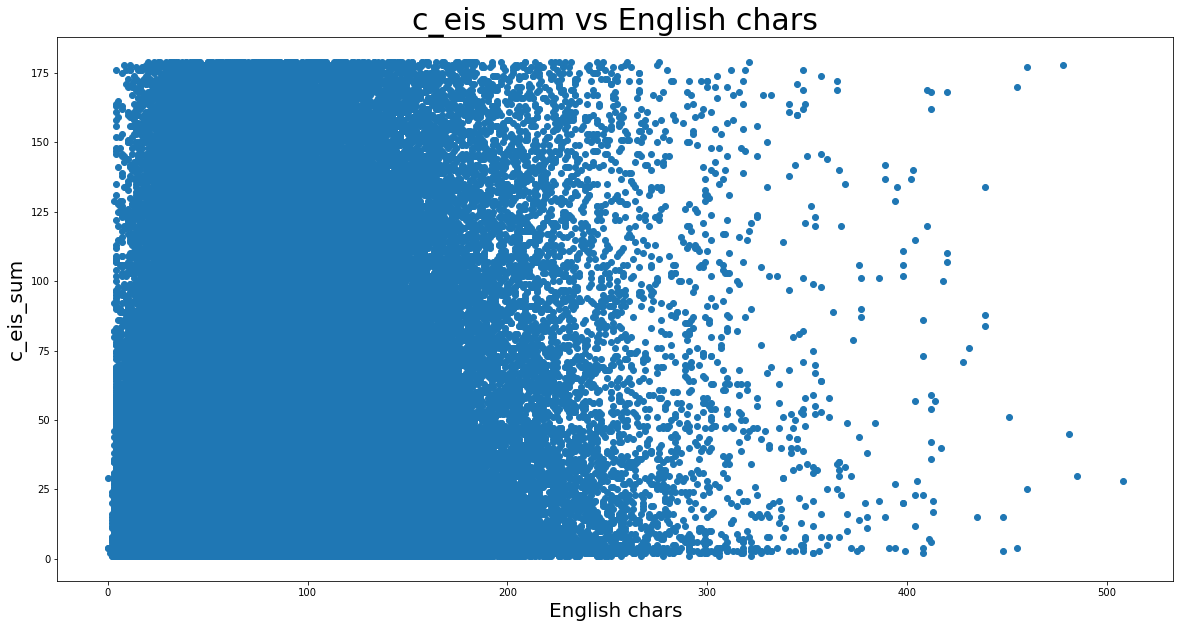

In [98]:
plt.figure(figsize=(20,10))
plt.title('c_eis_sum vs English chars', fontsize=30, color='black')
plt.xlabel('English chars', fontsize=20, color='black')
plt.ylabel('c_eis_sum', fontsize=20, rotation=90, color='black')
# plt.scatter(x='chars', y='c_eis_sum', data=df_deoutlrd);
# plt.scatter(x=df_deoutlrd['chars'], y=df_deoutlrd['c_eis_sum']);
plt.scatter(x='chars', y='c_eis_sum', data=df_deoutlrd.to_pandas());

## 8. Select ONLY TE contributions (first eyes)

In [80]:
df_deoutlrd_TEs = df_deoutlrd[df_deoutlrd['a_role']=='TE']; df_deoutlrd_TEs.shape

(222801, 15)

In [82]:
df_deoutlrd_TEs.loc[0:10,['m_descriptor','t_lan_E','t_senc','t_version','s_typ','s_rsen','chars','words','t_lan_CV','a_role','c_eis_sum','c_eis_count']]

,m_descriptor,t_lan_E,t_senc,t_version,s_typ,s_rsen,chars,words,t_lan_CV,a_role,c_eis_sum,c_eis_count
1,1963-0728,ENG,3714,15-0401,n,45,67,12,FIJ,TE,66,3
6,1963-0728,ENG,3714,15-0401,n,322,99,21,FIJ,TE,148,2
8,1963-0728,ENG,3714,15-0401,n,387,34,4,FIJ,TE,32,2
9,1963-0728,ENG,3714,15-0401,n,1153,14,4,FIJ,TE,66,2
10,1963-0728,ENG,3714,15-0401,n,1610,100,19,FIJ,TE,133,2


In [81]:
df_deoutlrd_TEs.head()

,m_descriptor,t_lan_E,t_senc,t_version,s_typ,s_rsen,e_content_E,chars,words,t_lan_CV,a_role,u_name,c_eis_sum,c_eis_count,e_content_CV
1,1948-0304,ENG,1165,15-0902,n,87,"[Blank.spot.on.tape — Ed.] feel the vibration,...",83,14,POR,TE,olisil,22,2,[Espaço em branco na fita - Ed.] sentir a vibr...
2,1948-0304,ENG,1165,15-0902,n,189,The thing that you're seeking after is already...,84,17,POR,TE,olisil,52,2,A coisa que procura já está no cofre do céu pa...
13,1948-0304,ENG,1165,15-0902,n,1098,"But tonight he's not coming, trying; he's comi...",70,14,POR,TE,olisil,49,2,"Mas esta noite ele não vira, a tentar; ele vem..."
15,1949-0718,ENG,700,15-0901,n,13,"O Father, I'm sure, with Divine faith, You wil...",70,13,GER,TE,lazbet,73,2,"O Vater, ich bin mir sicher, mit göttlichem Gl..."
18,1949-0718,ENG,700,15-0901,n,209,"And while I was in prayer here at the altar, a...",137,29,GER,TE,lazbet,108,2,"Und während ich hier am Altar im Gebet war, ei..."


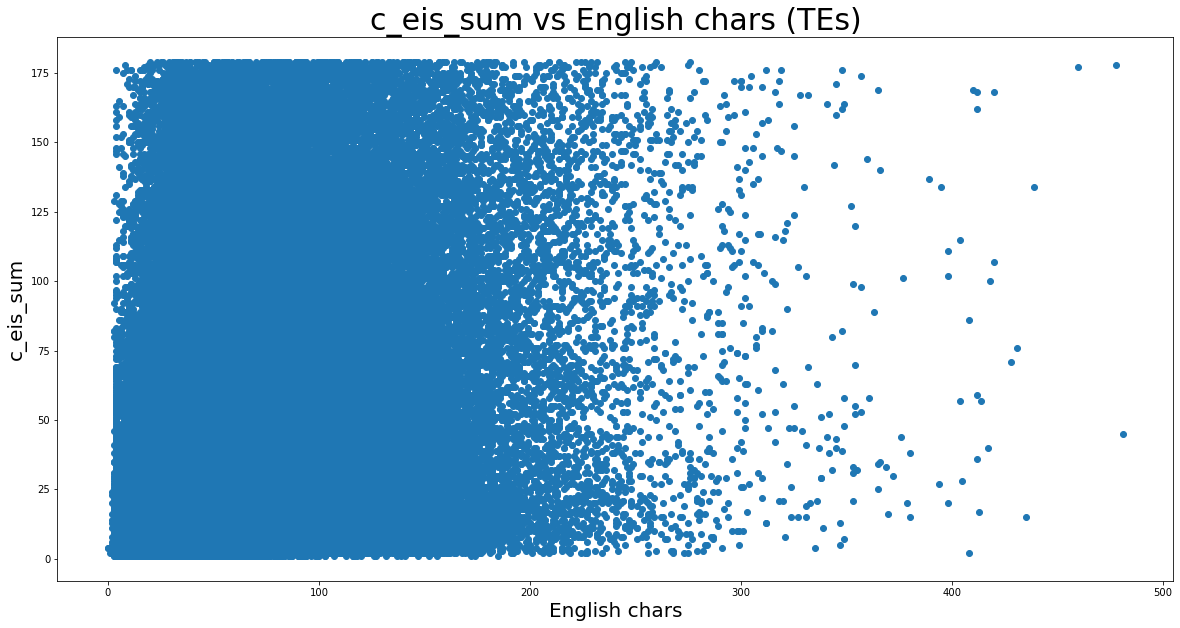

In [83]:
plt.figure(figsize=(20,10))
plt.title('c_eis_sum vs English chars (TEs)', fontsize=30, color='black')
plt.xlabel('English chars', fontsize=20, color='black')
plt.ylabel('c_eis_sum', fontsize=20, rotation=90, color='black')
plt.scatter(x='chars', y='c_eis_sum', data=df_deoutlrd_TEs.to_pandas());

## 9. Save prepared data to file

In [87]:
# hide
#- df_joind_EV.to_csv (f'{PATH}/PredictTranslationWordAndCharCount/PredictTranslationWordAndCharCount_1-output.csv', sep='~', index = False, header=True)

In [86]:
sdf = df_deoutlrd_TEs.to_spark()

csv_path = f"s3a://{bucket_str}/output/"
sdf.coalesce(1).orderBy(['m_descriptor','t_lan','t_version','s_rsen']).write.mode('overwrite').format( #1 is for a single file
 "com.databricks.spark.csv").option("header","true").option("sep","~").save(csv_path)

In [88]:
# 
# test
sdf = spark.read.csv(csv_path, sep='~', header=True, inferSchema=True, nanValue='null', nullValue='null')
# csv_df = spark.read.csv(csv_path, header=True, inferSchema = True)

In [89]:
kdf = sdf.to_koalas()

In [90]:
kdf.shape

(222801, 15)

In [91]:
kdf.columns

Index(['m_descriptor', 't_lan_E', 't_senc', 't_version', 's_typ', 's_rsen',
       'e_content_E', 'chars', 'words', 't_lan_CV', 'a_role', 'u_name',
       'c_eis_sum', 'c_eis_count', 'e_content_CV'],
      dtype='object')

In [92]:
kdf.loc[:5,['m_descriptor','t_lan_E','t_senc','t_version','s_typ','s_rsen','chars','words','t_lan_CV','a_role','c_eis_sum','c_eis_count']]

,m_descriptor,t_lan_E,t_senc,t_version,s_typ,s_rsen,chars,words,t_lan_CV,a_role,c_eis_sum,c_eis_count
0,1948-0304,ENG,1165,15-0902,n,1,102,21,GER,TE,107,2
1,1948-0304,ENG,1165,15-0902,n,1,102,21,POR,TE,50,2
2,1948-0304,ENG,1165,15-0902,n,2,27,6,GER,TE,12,1
3,1948-0304,ENG,1165,15-0902,n,2,27,6,POR,TE,9,1
4,1948-0304,ENG,1165,15-0902,n,3,36,7,GER,TE,9,1
5,1948-0304,ENG,1165,15-0902,n,3,36,7,POR,TE,9,1
